# Customer Churn Prediction with Random Forest Local Notebook

## Background

This notebook has been adapted from a notebook in SageMaker Example - [Customer Churn Prediction with XGBoost](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.html)

Losing customers is costly for any business. Identifying unhappy customers early on gives you a chance to offer them incentives to stay. This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

We use a familiar example of churn: leaving a mobile phone operator. Seems like one can always find fault with their provider du jour! And if the provider knows that a customer is thinking of leaving, it can offer timely incentives - such as a phone upgrade or perhaps having a new feature activated – and the customer may stick around. Incentives are often much more cost-effective than losing and reacquiring a customer.



## Setup

Ensure to install the latest `pandas` and `numpy`.

and import proper python packages.

In [3]:
import sys

!{sys.executable} -m pip install pandas numpy --upgrade


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import json
from IPython.display import display

import boto3 
import re

## Data

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes. After all, predicting the future is tricky business! But we’ll learn how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets. Let’s download and read that dataset in now:



In [9]:
s3 = boto3.client("s3")


s3.download_file(f"sagemaker-sample-files", "datasets/tabular/synthetic/churn.txt", "churn.csv")

In [10]:
churn = pd.read_csv("./churn.csv")
pd.set_option("display.max_columns", 500)
churn

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,806,403-2562,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,836,158-8416,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,777,896-6253,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,878,817-5729,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,878,450-4942,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,NH,4,787,151-3162,yes,yes,800,10.862632,5,7.250969,6.936164,1,8.026482,4.921314,350,6.748489,4.872570,8,2.122530,9,False.
4996,SD,140,836,351-5993,no,no,0,1.581127,8,3.758307,7.377591,7,1.328827,0.939932,300,4.522661,6.938571,2,4.600473,4,False.
4997,SC,32,836,370-3127,no,yes,700,0.163836,5,4.243980,5.841852,3,2.340554,0.939469,450,5.157898,4.388328,7,1.060340,6,False.
4998,MA,142,776,604-2108,yes,yes,600,2.034454,5,3.014859,4.140554,3,3.470372,6.076043,150,4.362780,7.173376,3,4.871900,7,True.


In [12]:
len(churn.columns), churn.columns

(21,
 Index(['State', 'Account Length', 'Area Code', 'Phone', 'Int'l Plan',
        'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge',
        'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls',
        'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge',
        'CustServ Calls', 'Churn?'],
       dtype='object'))

By modern standards, it’s a relatively small dataset, with only 5,000 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

* `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ

* `Account Length`: the number of days that this account has been active

* `Area Code`: the three-digit area code of the corresponding customer’s phone number

* `Phone`: the remaining seven-digit phone number

* `Int’l Plan`: whether the customer has an international calling plan: yes/no

* `VMail Plan`: whether the customer has a voice mail feature: yes/no

* `VMail Message`: the average number of voice mail messages per month

* `Day Mins`: the total number of calling minutes used during the day

* `Day Calls`: the total number of calls placed during the day

* `Day Charge`: the billed cost of daytime calls

* `Eve Mins`, `Eve Calls`, `Eve Charge`: the billed cost for calls placed during the evening

* `Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime

* `Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls

* `CustServ Calls`: the number of calls placed to Customer Service

* `Churn?`: whether the customer left the service: true/false

The last attribute, Churn?, is known as the target attribute: the attribute that we want the ML model to predict. Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

### Explorartory Data Analysis

In [15]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           5000 non-null   object 
 1   Account Length  5000 non-null   int64  
 2   Area Code       5000 non-null   int64  
 3   Phone           5000 non-null   object 
 4   Int'l Plan      5000 non-null   object 
 5   VMail Plan      5000 non-null   object 
 6   VMail Message   5000 non-null   int64  
 7   Day Mins        5000 non-null   float64
 8   Day Calls       5000 non-null   int64  
 9   Day Charge      5000 non-null   float64
 10  Eve Mins        5000 non-null   float64
 11  Eve Calls       5000 non-null   int64  
 12  Eve Charge      5000 non-null   float64
 13  Night Mins      5000 non-null   float64
 14  Night Calls     5000 non-null   int64  
 15  Night Charge    5000 non-null   float64
 16  Intl Mins       5000 non-null   float64
 17  Intl Calls      5000 non-null   i

In [13]:
# frequency tables for each categorical feature
for column in churn.select_dtypes(include=["object"]).columns:
    display(pd.crosstab(index=churn[column], columns="% observations", normalize="columns"))

col_0,% observations
State,
AK,0.0170
AL,0.0200
AR,0.0220
AZ,0.0180
CA,0.0208
CO,0.0182
CT,0.0178
DC,0.0224
DE,0.0182


col_0,% observations
Phone,
100-2030,0.0002
100-2118,0.0002
100-3505,0.0002
100-5224,0.0002
101-3371,0.0002
...,...
999-3178,0.0002
999-5498,0.0002
999-5816,0.0002


col_0,% observations
Int'l Plan,
no,0.5014
yes,0.4986


col_0,% observations
VMail Plan,
no,0.4976
yes,0.5024


col_0,% observations
Churn?,
False.,0.5004
True.,0.4996


,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,101.675800,773.791400,226.680000,5.518757,3.50460,5.018902,5.026199,3.140400,5.017557,4.000917,224.790000,5.023490,5.025876,5.475400,4.328242,5.525800
std,57.596762,63.470888,273.998527,3.433485,1.68812,2.195759,2.135487,2.525621,2.127857,1.631001,97.302875,1.748900,1.019302,1.877045,2.440311,2.041217
min,1.000000,657.000000,0.000000,0.000215,0.00000,0.004777,0.004659,0.000000,0.013573,0.008468,0.000000,0.054863,1.648514,0.000000,0.000769,0.000000
25%,52.000000,736.000000,0.000000,2.682384,2.00000,3.470151,3.588466,1.000000,3.529613,2.921998,150.000000,3.873157,4.349726,4.000000,2.468225,4.000000
50%,102.000000,778.000000,0.000000,5.336245,3.00000,4.988291,5.145656,3.000000,5.006860,3.962089,200.000000,5.169154,5.034905,5.000000,4.214058,6.000000
75%,151.000000,806.000000,400.000000,7.936151,5.00000,6.559750,6.552962,5.000000,6.491725,5.100128,300.000000,6.272015,5.716386,7.000000,5.960654,7.000000
max,200.000000,878.000000,1300.000000,16.897529,10.00000,12.731936,13.622097,14.000000,12.352871,10.183378,550.000000,10.407778,8.405644,12.000000,14.212261,13.000000


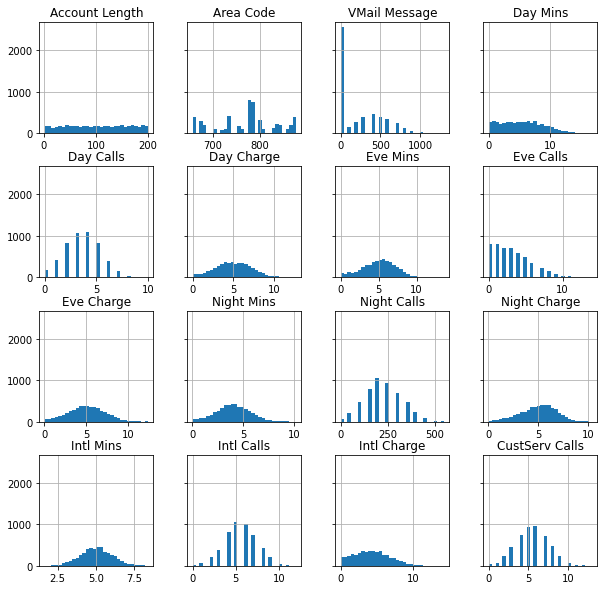

In [17]:
# histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

We can see immediately that: 
- `State` appears to be quite evenly distributed. 
- `Phone` takes on too many unique values to be of any practical use. It’s possible that parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it. 
- Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity. `VMail Message` is a notable exception (and Area Code showing up as a feature we should convert to non-numeric).

In [19]:
churn = churn.drop("Phone", axis=1)
churn["Area Code"] = churn["Area Code"].astype(object)

Next let’s look at the relationship between each of the features and our target variable.

In [21]:
for column in churn.select_dtypes(include=["object"]).columns:
    if column != "Churn?":
        display(pd.crosstab(index=churn[column], columns=churn["Churn?"], normalize="columns"))

Churn?,False.,True.
State,,
AK,0.015588,0.018415
AL,0.021583,0.018415
AR,0.022782,0.021217
AZ,0.015588,0.020416
CA,0.020384,0.021217
CO,0.018785,0.017614
CT,0.015588,0.020016
DC,0.022382,0.022418
DE,0.018385,0.018014


Churn?,False.,True.
Area Code,,
657,0.037170,0.036829
658,0.022782,0.021217
659,0.015588,0.020416
676,0.020384,0.021217
677,0.018785,0.017614
678,0.015588,0.020016
686,0.040767,0.040432
707,0.019984,0.015612
716,0.017986,0.015212


Churn?,False.,True.
Int'l Plan,,
no,0.5,0.502802
yes,0.5,0.497198


Churn?,False.,True.
VMail Plan,,
no,0.496403,0.498799
yes,0.503597,0.501201


Account Length


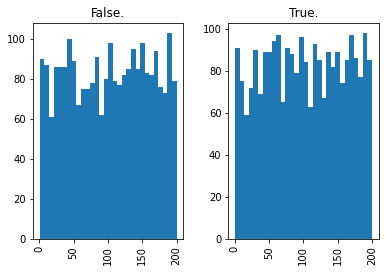

VMail Message


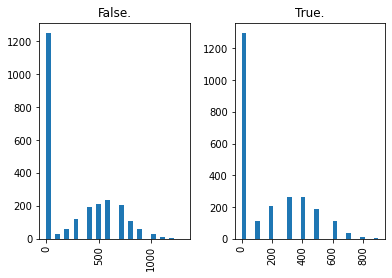

Day Mins


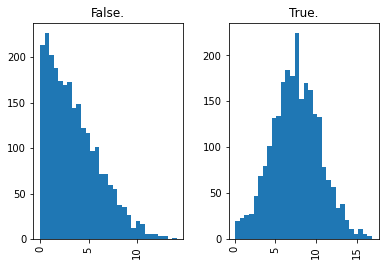

Day Calls


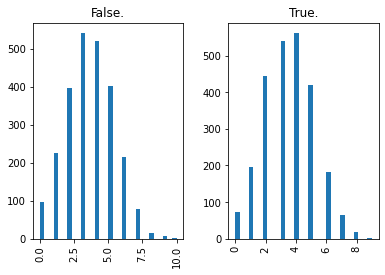

Day Charge


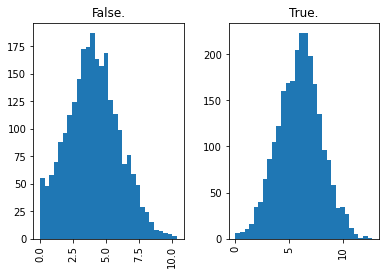

Eve Mins


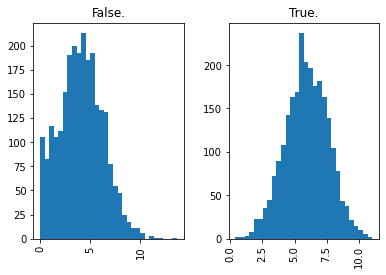

Eve Calls


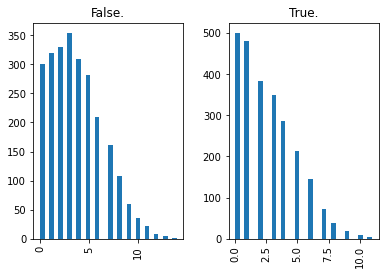

Eve Charge


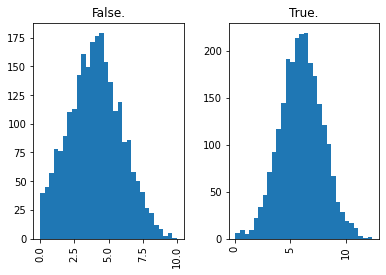

Night Mins


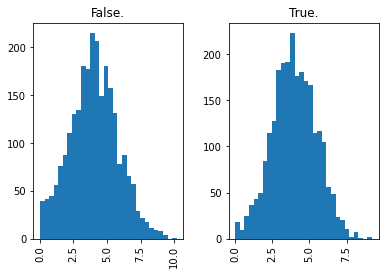

Night Calls


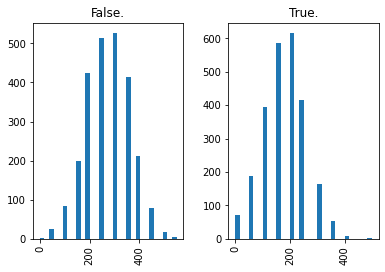

Night Charge


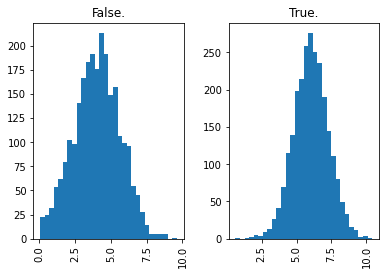

Intl Mins


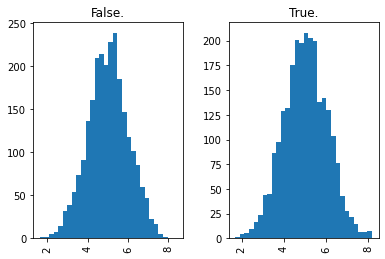

Intl Calls


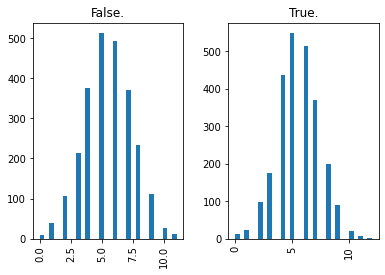

Intl Charge


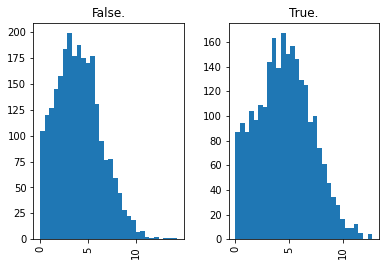

CustServ Calls


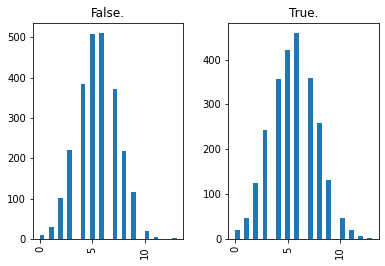

In [22]:
for column in churn.select_dtypes(exclude=["object"]).columns:
    print(column)
    hist = churn[[column, "Churn?"]].hist(by="Churn?", bins=30)
    plt.show()

In [24]:
display(churn.corr())
# pd.plotting.scatter_matrix(churn, figsize=(12, 12))
# plt.show()

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.009030,-0.015878,0.011659,-0.007468,0.000213,0.026515,-0.012795,0.016400,-0.002383,-0.034925,0.017277,-0.003735,0.028285,-0.036721
VMail Message,-0.009030,1.000000,-0.143272,0.002762,-0.182712,-0.104667,-0.101240,-0.029212,0.061370,0.135042,-0.155475,-0.015162,0.131964,0.010120,0.068657
Day Mins,-0.015878,-0.143272,1.000000,-0.087598,0.667941,0.482641,-0.184939,0.766489,0.188190,-0.445212,0.570508,0.001988,0.236131,0.239331,-0.195322
Day Calls,0.011659,0.002762,-0.087598,1.000000,-0.222556,0.033903,0.185881,-0.052051,-0.085222,-0.083050,0.046641,-0.022548,-0.045671,-0.120064,-0.065518
Day Charge,-0.007468,-0.182712,0.667941,-0.222556,1.000000,0.574697,0.236626,0.371580,0.150700,-0.130722,0.374861,0.010294,0.119584,0.251748,-0.260945
Eve Mins,0.000213,-0.104667,0.482641,0.033903,0.574697,1.000000,-0.067123,0.269980,-0.090515,0.067315,0.317481,-0.015678,0.070456,0.448910,-0.167347
Eve Calls,0.026515,-0.101240,-0.184939,0.185881,0.236626,-0.067123,1.000000,-0.467814,0.221439,0.218149,-0.324936,-0.001593,-0.112062,0.017036,-0.433467
Eve Charge,-0.012795,-0.029212,0.766489,-0.052051,0.371580,0.269980,-0.467814,1.000000,0.184230,-0.454649,0.546137,-0.003569,0.164104,0.243936,-0.011019
Night Mins,0.016400,0.061370,0.188190,-0.085222,0.150700,-0.090515,0.221439,0.184230,1.000000,-0.223023,-0.140482,-0.012781,0.038831,0.271179,-0.332802
Night Calls,-0.002383,0.135042,-0.445212,-0.083050,-0.130722,0.067315,0.218149,-0.454649,-0.223023,1.000000,-0.390333,-0.009821,0.181237,-0.155736,0.110211


We see several features that essentially have 100% correlation with one another. Including these feature pairs in some machine learning algorithms can create catastrophic problems, while in others it will only introduce minor redundancy and bias. Let’s remove one feature from each of the highly correlated pairs: `Day Charge` from the pair with `Day Mins`, `Night Charge` from the pair with `Night Mins`, `Intl Charge` from the pair with `Intl Mins`:

In [25]:
churn = churn.drop(["Day Charge", "Eve Charge", "Night Charge", "Intl Charge"], axis=1)

Now that we’ve cleaned up our dataset, let’s determine which algorithm to use. As mentioned above, there appear to be some variables where both high and low (but not intermediate) values are predictive of churn. In order to accommodate this in an algorithm like linear regression, we’d need to generate polynomial (or bucketed) terms.

We should use Random Forest Algorithm in SKLearn framework to train a model for the problem.

### Data Transformation

Convert our categorical features into numeric features.

In [27]:
model_data = pd.get_dummies(churn)
model_data = pd.concat(
    [model_data["Churn?_True."], model_data.drop(["Churn?_False.", "Churn?_True."], axis=1)], axis=1
)    

In [28]:
model_data.head()

,Churn?_True.,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area Code_657,Area Code_658,Area Code_659,Area Code_676,Area Code_677,Area Code_678,Area Code_686,Area Code_707,Area Code_716,Area Code_727,Area Code_736,Area Code_737,Area Code_758,Area Code_766,Area Code_776,Area Code_777,Area Code_778,Area Code_786,Area Code_787,Area Code_788,Area Code_797,Area Code_798,Area Code_806,Area Code_827,Area Code_836,Area Code_847,Area Code_848,Area Code_858,Area Code_866,Area Code_868,Area Code_876,Area Code_877,Area Code_878,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes
0,1,163,300,8.162204,3,3.933035,4,4.065759,100,4.928160,6,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,0,15,0,10.018993,4,2.325005,0,7.141040,200,3.221748,6,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
2,0,131,300,4.708490,3,4.537466,3,5.363235,100,7.139023,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,0,75,700,1.268734,3,2.528748,5,3.773586,450,2.245779,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
4,1,146,0,2.696177,3,6.015337,3,3.751673,250,6.905545,4,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score

In [40]:
df = model_data.sample(frac=1, random_state=29).reset_index(drop=True)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, 1:], 
    df.iloc[:, 0],
    test_size=0.15, random_state=23)

In [42]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4250, 99), (4250,), (750, 99), (750,))

In [46]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_sc = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Model Training with Random Forest

In [53]:
%%time

param_rf = {
    "bootstrap": [True],
    "max_depth": [10, 11, 12, 13],
    "max_features": [10, 11, 12, 13, 14],
    "n_estimators": [100, 200, 300]
}

model = RandomForestClassifier()

grid_search = GridSearchCV(model, param_rf, cv=5, n_jobs=-1)
grid_search.fit(X_train_sc, y_train)
print(grid_search.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features=14,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
CPU times: user 3.23 s, sys: 23.3 ms, total: 3.25 s
Wall time: 4min 2s


## Model Evaluation

In [54]:
def evaluate_performance(y_test, y_pred):
    print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))
    print('====================')
    print("Accuracy : ", "{:.2f}".format(accuracy_score(y_test, y_pred)))
    print("Precision : ", "{:.2f}".format(precision_score(y_test, y_pred)))
    print("Recall : ","{:.2f}".format(recall_score(y_test, y_pred)))
    print("F1 :", "{:.2f}".format(f1_score(y_test, y_pred)))


In [55]:
y_pred = grid_search.predict(X_test_sc)
evaluate_performance(y_test, y_pred)

Predicted    0    1
Actual             
0          349   32
1           21  348
Accuracy :  0.93
Precision :  0.92
Recall :  0.94
F1 : 0.93
